# MI-SCR - zkouška

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from statsmodels.api import qqplot

## Načtení dat

Data popisují průměrné měsíční teploty za 20 let v Nottingham Castle ve stupních Fahrhenheita. Data jsou dostupná z odkazu: https://datamarket.com/data/set/22li/mean-monthly-air-temperature-deg-f-nottingham-castle-1920-1939#!ds=22li&display=line

In [2]:
df = pd.read_csv('data.csv', sep=';')
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month', 'Temperature']
df.set_index('Month', inplace = True)

In [3]:
df.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


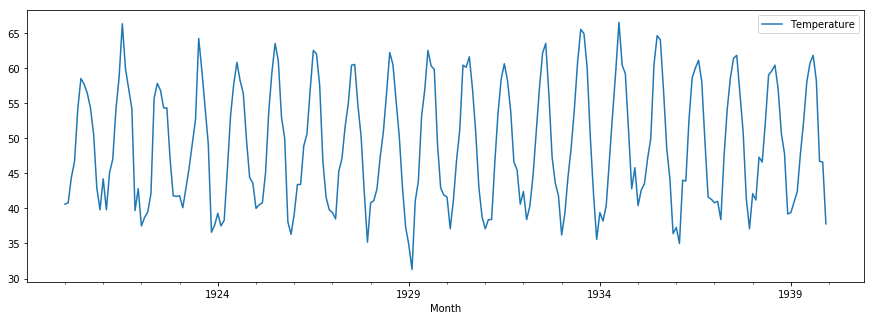

In [4]:
df.plot(figsize=(15,5))

## Základní pohled na data

Jedná se o měsíční průměry teplot, proto je výše vykreslený graf poměrně nepřekvapivý. V datech je jasně patrná sezónnost s periodou 12 měsíců, což odpovída tomu co bychom u těchto dat čekali. V datech není patrný žádný trend, znovu v souladu s očekáváním.

## Rozklad časové řady

Nyni rozložíme časovou řadu za pomoci statsmodels na jednotlivé komponenty. Pro tuto řadu je vidět, že je amplituda sezónních složek přibližně stejná, proto zvolíme additivní model.

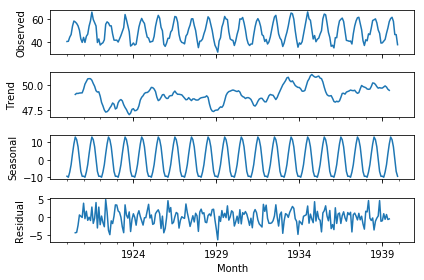

In [5]:
series = df['Temperature']
result = seasonal_decompose(df['Temperature'], freq=12, model='additive')
result.plot()
plt.show()

Z výše vykresleného grafu jsou krásně patrné jednotlivé sezóny. Složka trendu rovněž nevykazuje rostoucí ani klesající chování, a celkový pohyb je v rozsahu cca 2°F, což podle mě není příliš vyznamné. Graf reziduí vypadá rozumně, dle pohledu vypadá i na slabě stacionární.

In [6]:
# Okopirovano z https://github.com/kamil-dedecius/mi-scr/blob/master/zdrojaky/tsplot.py :)
def tsplot(y, lags=15):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    # layout
    fig = plt.figure(figsize=(14, 6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    # ts plot
    y.plot(ax=ts_ax)
    ts_ax.set_title('Time series');
    
    # acf, pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

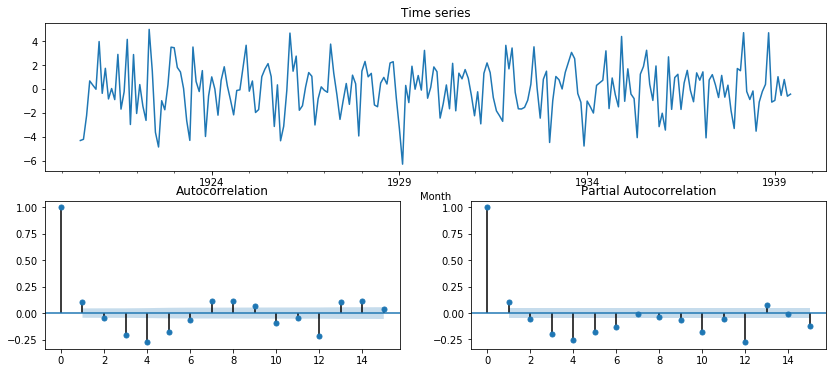

In [7]:
tsplot(result.resid.dropna())

Z grafů ACF a PACF reziduí vidíme, že v modelu který používa seasonal_decompose je zřejně ještě nějaká nevysvetlěná část. Při dalším modelování se ji budeme snažit odstranit

# Modelování řady

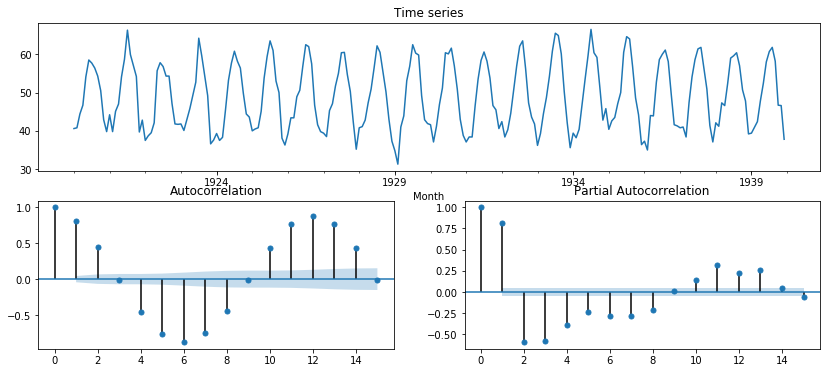

In [8]:
tsplot(df["Temperature"])

Dle ACF a PACF nevykazuje řada ani čistě AR ani čistě MA charakteristiku. Na modelování této řady bych zvolil - vzhledem k sezonosti model SARIMA. Řada nevykazuje rostoucí ani klesající trend (v horizontu 20 let by to vzhledem k tomu, co to je za data, ani příliš nedávalo smysl), tudíž bych volil variantu bez integrace, ale uvidime po vyzkouseni parametru. Nyní zkusíme odhadnout parametry.

### Zkoušení parametrů

In [9]:
warnings.filterwarnings("ignore")
res = []
r = range(0,3)
r_integration = range(0,2) # Integrujeme max 1x
cnt, total = 1, 324
for xs in itertools.product(r,r_integration,r,r,r_integration,r):
    try:
        model = SARIMAX(df["Temperature"], order=(xs[:3]), seasonal_order=xs[3:]+(12,))
        result = model.fit()
        aic = result.aic
        res.append((xs, aic))
        
        if ((cnt % 20) == 0):
            print(f'Processed {cnt} out of {total}.')
        cnt += 1
    except:
        if ((cnt % 20) == 0):
            print(f'Processed {cnt} out of {total}.')
        cnt += 1
        continue

Processed 20 out of 324.
Processed 40 out of 324.
Processed 60 out of 324.
Processed 80 out of 324.
Processed 100 out of 324.
Processed 120 out of 324.
Processed 140 out of 324.
Processed 160 out of 324.
Processed 180 out of 324.
Processed 200 out of 324.
Processed 220 out of 324.
Processed 240 out of 324.
Processed 260 out of 324.
Processed 280 out of 324.
Processed 300 out of 324.
Processed 320 out of 324.


Nyní seřadíme výsledné varianty parametrů podle AIC a vybereme ten nejlepší. Zároveň ale chceme zachovat co nejjednodušší model, tak k tomu také přihlédneme.

In [10]:
res = sorted(res, key=lambda x: x[1]) #sort by AIC
for i in res[:10]:
    print(f'SARIMAX({i[0][:3]})x({i[0][3:]})12, {i[1]}')

SARIMAX((2, 0, 2))x((0, 1, 2))12, 1043.1184110432796
SARIMAX((1, 0, 0))x((2, 1, 1))12, 1044.2086897098197
SARIMAX((1, 0, 0))x((1, 1, 1))12, 1044.4881063025994
SARIMAX((0, 0, 2))x((1, 1, 1))12, 1044.7946601218412
SARIMAX((1, 0, 0))x((1, 1, 2))12, 1044.820189564298
SARIMAX((0, 0, 2))x((2, 1, 1))12, 1045.0662005019012
SARIMAX((2, 0, 0))x((2, 1, 1))12, 1045.076889387848
SARIMAX((2, 0, 0))x((1, 1, 1))12, 1045.1926717486579
SARIMAX((1, 0, 1))x((2, 1, 1))12, 1045.3058542146455
SARIMAX((1, 0, 1))x((1, 1, 1))12, 1045.5463553815302


Nejlépe vypadá model SARIMAX((1, 0, 0))x((1, 1, 1))12, s hodnotou AIC 1044.488. Nyní zkusíme model nafitovat.

### Fitování modelu

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1044.4881063026673


<Figure size 1080x216 with 0 Axes>

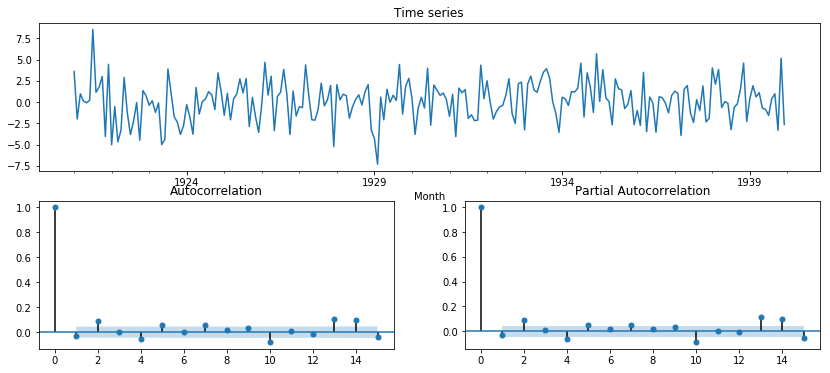

                                 Statespace Model Results                                 
Dep. Variable:                        Temperature   No. Observations:                  240
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood                -518.244
Date:                            Thu, 20 Dec 2018   AIC                           1044.488
Time:                                    12:45:52   BIC                           1058.205
Sample:                                01-01-1920   HQIC                          1050.023
                                     - 12-01-1939                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2739      0.063      4.379      0.000       0.151       0.396
ar.S.L12      -0.2966      0.079   

In [7]:
model = SARIMAX(df["Temperature"], order=(1,0,0), seasonal_order=(1,1,1,12))
result = model.fit()
print(result.aic)

plt.figure(figsize=(15,3))
tsplot(result.resid[12:]) # Drop first 12 values
plt.show()

print(result.summary())

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


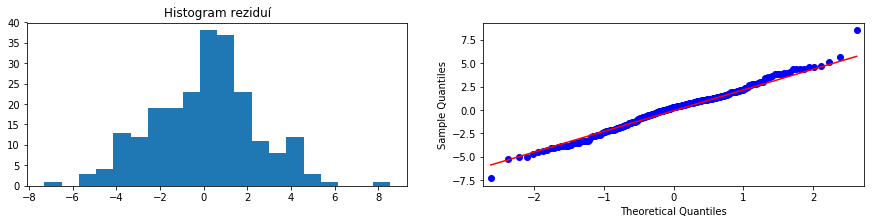

In [8]:
plt.figure(figsize=(15,3))
ax = plt.subplot(1,2,1)
plt.hist(result.resid[12:], bins=20)
plt.title('Histogram reziduí')
ax = plt.subplot(1,2,2)
qqplot(result.resid[12:], line='q', ax=ax)
plt.show()


ACF i PACF residuí vypadá dobře, stejně tak i graf a histogramy. Celkově je tedy možné prohlásit, že použitý model se chová pěkně.

### Predikce

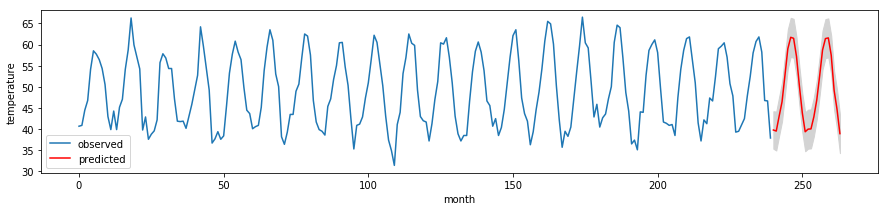

In [9]:
data = df["Temperature"]
nsteps = 24
forecast = result.get_forecast(steps=nsteps, simple_differencing=True)
plt.figure(figsize=(15,3))
plt.plot(np.arange(data.size), data, label='observed')
plt.plot(np.arange(data.size, data.size+forecast.predicted_mean.size), 
         forecast.predicted_mean, 'r', label='predicted')
plt.fill_between(np.arange(data.size, data.size+forecast.predicted_mean.size), 
                 forecast.summary_frame()['mean_ci_lower'],
                 forecast.summary_frame()['mean_ci_upper'],
                 color='lightgray')
plt.legend()
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

Predikce na 2 roky dopředu vypadají rovněž rozumně. Ve výsledku je možné prohlásit, že se nám podařilo sestavit poměrně slušný model pro naše data.